### IMPORTAMOS LIBRERÍAS

In [1]:
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns
import lightgbm as lgb

### ALGUNOS AJUSTES INICIALES

In [2]:
# Display all columns in the dataframe
pd.set_option('display.max_columns', None)

# Set plot size
plt.rcParams['figure.figsize'] = (20, 6)

# File paths
INPUT_PATH = "./input_data"
FILE_NAME = "InputOutput_Results.csv"

### AHORA DEFINIMOS ALGUNAS FUNCIONES GENÉRICAS

In [3]:
def load_data(input_path, file_name):
    """
    Load data from a CSV file and perform initial preprocessing.
    """
    df = pd.read_csv(os.path.join(input_path, file_name), sep=",")
    #df = df.drop(["Unnamed: 0"], axis=1)
    df = df.drop(["caseID", "EnvID"], axis=1)
    df = df.sort_values(["EnvTime"])
    return df


def encode_angles(df, angular_cols):
    """
    Encode angular columns using sine and cosine transformations.
    """
    for col in angular_cols:
        print(f"Encoding angular variable ---> {col}")
        df["cos_" + col] = np.cos(np.radians(df[col]))
        df["sin_" + col] = np.sin(np.radians(df[col]))
    return df

def save_model(model_name, model, light_gbm=False):
    """
    Save the model to a file.
    """
    directory = os.path.join("drift_prediction_utils/Models", model_name + (".txt" if light_gbm else ".pkl"))
    if light_gbm:
        model.booster_.save_model(directory)
    else:
        joblib.dump(model, directory, compress=3)
    print(f"Model saved to {directory}")

def angular_difference(y_true, y_pred):
    """
    Calculate the angular difference between true and predicted angles.
    """
    diff = np.abs(y_true - y_pred)
    diff = np.where(diff > 180, 360 - diff, diff)
    return diff

### CARGA DEL DATASET

In [4]:
# Load data
df_input = load_data(INPUT_PATH, FILE_NAME)
print(f"DataFrame dimensions: {df_input.shape}")

DataFrame dimensions: (50000, 20)


In [5]:
df_input

,EnvTime,WindSpeed,WindDir,WaveHs,WaveTp,WaveDir,CurrSpeed,CurrDir,x0,y0,dist0,heading0,time_closest,x_closest,y_closest,dist_closest,heading_closest,DriftDirection_closest,velocity_closest,HitBool
10730,1993-01-01 14:00:00,10.493,11.048,1.854,10.375,59.365,0.200,76.126,963.511,-1309.358,1625.660,215.0,-1.0,963.511,-1309.358,1625.660,215.000,0.000,0.000,0
27659,1993-01-01 19:00:00,11.648,0.237,1.921,5.672,39.220,0.147,133.069,992.718,-1253.251,1598.789,200.0,-1.0,992.718,-1253.251,1598.789,200.000,0.000,0.000,0
4668,1993-01-02 00:00:00,11.305,12.199,2.092,6.248,44.343,0.197,54.897,974.868,-1291.530,1618.152,210.0,-1.0,974.868,-1291.530,1618.152,210.000,0.000,0.000,0
34204,1993-01-02 05:00:00,12.637,19.779,2.617,7.524,50.553,0.233,114.515,950.643,-1326.127,1631.666,220.0,-1.0,950.643,-1326.127,1631.666,220.000,0.000,0.000,0
42613,1993-01-03 07:00:00,13.298,1.477,2.625,6.870,15.491,0.359,131.973,999.074,-1233.092,1587.030,195.0,-1.0,999.074,-1233.092,1587.030,195.000,0.000,0.000,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14546,2022-07-30 20:00:00,7.262,4.920,1.374,6.877,54.435,0.195,33.499,974.868,-1291.530,1618.152,210.0,-1.0,974.868,-1291.530,1618.152,210.000,0.000,0.000,0
32963,2022-07-31 13:00:00,8.473,181.971,0.876,3.847,131.836,0.188,168.551,526.411,-1212.455,1321.800,350.0,493.3,434.102,-1236.069,1310.081,5.682,160.644,0.386,0
14846,2022-07-31 17:00:00,9.576,153.957,1.094,4.201,151.651,0.185,187.977,545.432,-1272.780,1384.726,335.0,98.0,540.745,-1274.739,1384.689,334.857,157.024,0.102,0
26161,2022-07-31 19:00:00,8.871,155.872,1.142,4.848,150.755,0.056,189.660,545.432,-1272.780,1384.726,335.0,-0.5,545.432,-1272.780,1384.726,335.000,155.307,0.000,0


#### NECESITAMOS FILTRAR OLAS > 15 m como condición inicial (no se realiza la operación)

In [6]:
df_filt_1 = df_input.loc[df_input['WaveHs'] < 15]
print(f"DataFrame dimensions: {df_filt_1.shape}")

DataFrame dimensions: (50000, 20)


In [7]:
# Encode angular variables
angular_cols = ["WindDir", "WaveDir", "CurrDir", "heading0"]
df = encode_angles(df_filt_1, angular_cols)
df.head(2)

Encoding angular variable ---> WindDir
Encoding angular variable ---> WaveDir
Encoding angular variable ---> CurrDir
Encoding angular variable ---> heading0


,EnvTime,WindSpeed,WindDir,WaveHs,WaveTp,WaveDir,CurrSpeed,CurrDir,x0,y0,dist0,heading0,time_closest,x_closest,y_closest,dist_closest,heading_closest,DriftDirection_closest,velocity_closest,HitBool,cos_WindDir,sin_WindDir,cos_WaveDir,sin_WaveDir,cos_CurrDir,sin_CurrDir,cos_heading0,sin_heading0
10730,1993-01-01 14:00:00,10.493,11.048,1.854,10.375,59.365,0.200,76.126,963.511,-1309.358,1625.660,215.0,-1.0,963.511,-1309.358,1625.660,215.0,0.0,0.0,0,0.981467,0.191631,0.509567,0.860431,0.239788,0.970825,-0.819152,-0.573576
27659,1993-01-01 19:00:00,11.648,0.237,1.921,5.672,39.220,0.147,133.069,992.718,-1253.251,1598.789,200.0,-1.0,992.718,-1253.251,1598.789,200.0,0.0,0.0,0,0.999991,0.004136,0.774724,0.632300,-0.682879,0.730532,-0.939693,-0.342020


### NECESITAMOS ALGUNAS LIBRERÍAS ADICIONALES PARA EL TRAINING

In [8]:
from sklearn.multioutput import MultiOutputRegressor
from sklearn.ensemble import RandomForestRegressor, HistGradientBoostingRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_absolute_error, recall_score, precision_score, balanced_accuracy_score, precision_recall_curve, confusion_matrix, ConfusionMatrixDisplay, roc_auc_score, roc_curve, classification_report
import joblib
import shap

C:\Users\lords\anaconda3\envs\repsol_drift\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Y DEFINIR ALGUNAS FUNCIONES MÁS PARA EL ENTRENAMIENTO Y EVALUACIÓN DE LOS MODELOS

In [15]:
def train_heading_model(X_train, y_train):
    """
    Train the heading prediction model using MultiOutputRegressor and HistGradientBoostingRegressor.
    """
    model = MultiOutputRegressor(HistGradientBoostingRegressor(random_state=42, max_iter=20000))
    model.fit(X_train, y_train)
    return model

def evaluate_heading_model(model, X_test, y_test, heading0_test):
    """
    Evaluate the heading prediction model and plot the results.
    """
    y_pred = model.predict(X_test)

    # Compute metrics
    r2_sin = r2_score(y_test['sin_heading0'], y_pred[:, 0])
    r2_cos = r2_score(y_test['cos_heading0'], y_pred[:, 1])
    mae_sin = mean_absolute_error(y_test['sin_heading0'], y_pred[:, 0])
    mae_cos = mean_absolute_error(y_test['cos_heading0'], y_pred[:, 1])

    # Compute the angle using arctan2
    angle_radians = np.arctan2(y_pred[:, 0], y_pred[:, 1])
    angle_degrees = np.degrees(angle_radians)
    angle_degrees_predicted = (angle_degrees + 360) % 360

    df_plot = pd.DataFrame({"x": range(len(y_test)), "y_test": heading0_test, "y_predict": angle_degrees_predicted})

    # Print metrics
    print(f'R2 for sin_heading0: {r2_sin}')
    print(f'R2 for cos_heading0: {r2_cos}')
    print(f'Mean Absolute Error for sin_heading0: {mae_sin}')
    print(f'Mean Absolute Error for cos_heading0: {mae_cos}')

    angular_diff = angular_difference(df.loc[y_test.index].heading0, angle_degrees_predicted )
    df_plot["diff"] = angular_diff
    mae_heading0 = np.mean(angular_diff)
    print(f'Mean Absolute Error para heading0: {mae_heading0}')

    # Plot predictions
    # fig = px.scatter(df_plot.sample(200), x="x", y=["y_test", "y_predict"], title='Predicted vs True Values for Heading0')
    # fig.show()
    # Create the scatter plot
    plt.figure(figsize=(10, 6))
    
    # Plot true values
    sns.scatterplot(x='x', y='y_test', data=df_plot, color='blue', label='True Values', alpha=0.6)
    
    # Plot predicted values
    sns.scatterplot(x='x', y='y_predict', data=df_plot, color='orange', label='Predicted Values', alpha=0.6)
    
    # Add trend line for true values
    sns.regplot(x='x', y='y_test', data=df_plot, scatter=False, color='blue', line_kws={'label': 'Trend Line (True Values)'})
    
    # Add trend line for predicted values
    sns.regplot(x='x', y='y_predict', data=df_plot, scatter=False, color='orange', line_kws={'label': 'Trend Line (Predicted Values)'})
    
    # Enhance the plot
    plt.title('Predicted vs True Values for Heading0', fontsize=15, fontweight='bold')
    plt.xlabel('X', fontsize=12)
    plt.ylabel('Values', fontsize=12)
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    
    # Show the plot
    plt.show()

    return mae_heading0

def train_classification_model(X_train, y_train, params):
    """
    Train a LightGBM classification model.
    """
    model = lgb.LGBMClassifier(**params)
    model.fit(X_train, y_train, eval_set=[(X_train, y_train)], feature_name=X_train.columns.tolist())
    return model

def evaluate_classification_model(model, X_test, y_test):
    """
    Evaluate the classification model and plot the results.
    """
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1]

    roc_auc = roc_auc_score(y_test, y_proba)
    recall = recall_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    balanced_acc = balanced_accuracy_score(y_test, y_pred)

    print(f"ROC AUC: {roc_auc}")
    print(f"Recall: {recall}")
    print(f"Precision: {precision}")
    print(f"Balanced Accuracy: {balanced_acc}")

    print(classification_report(y_test, y_pred, target_names=["No_Hit", "Hit"]))

    fpr, tpr, _ = roc_curve(y_test, y_proba)
    plt.plot(fpr, tpr)
    plt.title("ROC Curve")
    plt.show()

    lr_precision, lr_recall, _ = precision_recall_curve(y_test, y_proba)
    plt.plot(lr_recall, lr_precision, marker='.')
    plt.title("Precision-Recall Curve")
    plt.show()

    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["No_Hit", "Hit"])
    disp.plot()
    plt.show()

def train_drift_model(X_train, y_train):
    """
    Train the drift prediction model using MultiOutputRegressor and RandomForestRegressor.
    """
    rf = RandomForestRegressor(random_state=42, n_estimators=2000, min_samples_split=2, min_samples_leaf=1)
    model = MultiOutputRegressor(rf)
    model.fit(X_train, y_train)
    return model

def evaluate_drift_model(model, X_test, y_test):
    """
    Evaluate the drift prediction model and plot the results.
    """
    y_pred = model.predict(X_test)

    r2_train = r2_score(y_test, y_pred)
    mae_train = mean_absolute_error(y_test, y_pred)

    print(f'R2: {r2_train}')
    print(f'MAE: {mae_train}')

    df_drift_error = pd.DataFrame({"x_closest": y_test["x_closest"], "y_closest": y_test["y_closest"], "x_pred": y_pred[:, 0], "y_pred": y_pred[:, 1]})

    plt.scatter(range(len(y_pred[:100])), y_pred[:100, 0])
    plt.scatter(range(len(y_test[:100])), y_test["x_closest"][:100])
    plt.legend(["predict", "real"])
    plt.title("X results")
    plt.show()

    plt.scatter(range(len(y_pred[:100])), y_pred[:100, 1])
    plt.scatter(range(len(y_test[:100])), y_test["y_closest"][:100])
    plt.legend(["predict", "real"])
    plt.title("Y results")
    plt.show()

### AHORA VAMOS A PREPARAR LOS DATOS DE ENTRENAMIENTO

In [16]:
# Define predictor and target columns
predictor_cols = ['cos_WindDir', 'sin_WindDir', 'cos_WaveDir', 'sin_WaveDir', 'cos_CurrDir', 'sin_CurrDir', 
                  'WindSpeed', 'WaveHs', 'WaveTp', 'CurrSpeed', "WindDir", "WaveDir", "CurrDir"]
target_cols = ['heading0', 'cos_heading0', 'sin_heading0']

# Train - Test splitting for target and predictor cols
X = df[predictor_cols]
target_cols = ["heading0", "sin_heading0", "cos_heading0"]
y = df[target_cols]

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
heading0_train, heading0_test = y_train["heading0"], y_test["heading0"]

# Drop heading0 from y_train and y_test
y_train.drop(["heading0"], inplace=True, axis=1)
y_test.drop(["heading0"], inplace=True, axis=1)

print("Features used by the model:", X_train.columns)
print("Target features for the model:", y_train.columns)

#Scale the numerical features (it actually increases the error to 5.09
# scaler = StandardScaler()
# X_train = scaler.fit_transform(X_train)
# X_test = scaler.transform(X_test)

Features used by the model: Index(['cos_WindDir', 'sin_WindDir', 'cos_WaveDir', 'sin_WaveDir',
       'cos_CurrDir', 'sin_CurrDir', 'WindSpeed', 'WaveHs', 'WaveTp',
       'CurrSpeed', 'WindDir', 'WaveDir', 'CurrDir'],
      dtype='object')
Target features for the model: Index(['sin_heading0', 'cos_heading0'], dtype='object')


### FINALMENTE ENTRENAMOS Y EVALUAMOS CADA UNO DE LOS MODELOS

#### MODEL 1: HEADING0

R2 for sin_heading0: 0.9653374963200603
R2 for cos_heading0: 0.9616183054026918
Mean Absolute Error for sin_heading0: 0.05428380688839452
Mean Absolute Error for cos_heading0: 0.0605153611484056
Mean Absolute Error para heading0: 4.860227376102274


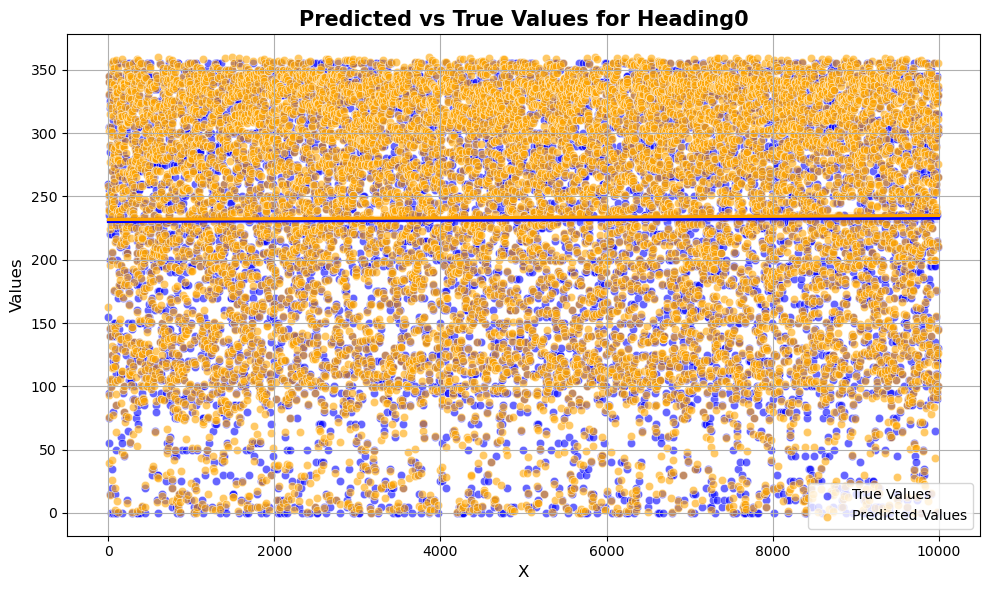

In [17]:
# Train and evaluate the heading model
heading_model = train_heading_model(X_train, y_train)
mae_heading0 = evaluate_heading_model(heading_model, X_test, y_test, heading0_test)
#save_model("heading0_model", heading_model)

#### MDOEL 2:HITBOOL PROB

In [ ]:
# Define parameters for the classification model
classification_params = {
    'colsample_bytree': 0.8,
    'learning_rate': 0.1,
    'max_depth': 10,
    'n_estimators': 500,
    'num_leaves': 50,
    'reg_alpha': 0,
    'reg_lambda': 0.2,
    'subsample': 0.8
}

# Train and evaluate the classification model
hitbool2_X_train, hitbool2_X_test, hitbool2_y_train, hitbool2_y_test = split_data(df, predictor_cols, ["hitbool2"])
classification_model = train_classification_model(hitbool2_X_train, hitbool2_y_train, classification_params)
evaluate_classification_model(classification_model, hitbool2_X_test, hitbool2_y_test)
save_model("hitbool2_model", classification_model)

#### MODEL 3: DRIFT PREDICTION

##### FIRST WE WILL USE THE SAME PROCEDURE

In [ ]:
# Define predictor and target columns
predictor_cols = predictor_cols = [
    "WindSpeed", "WindDir", "cos_WindDir", "sin_WindDir", "WaveHs", "WaveTp", 
    "WaveDir", "cos_WaveDir", "sin_WaveDir", "CurrDir", "cos_CurrDir", "sin_CurrDir",
    "CurrSpeed" ,
    "sin_heading0_pred",  "cos_heading0_pred", "heading0_pred"
]
target_cols = ["x_closest", "y_closest"]

# Train - Test splitting for target and predictor cols
X = df[predictor_cols]
y = df[target_cols]

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
heading0_train, heading0_test = y_train["heading0"], y_test["heading0"]

# Drop heading0 from y_train and y_test
y_train.drop(["heading0"], inplace=True, axis=1)
y_test.drop(["heading0"], inplace=True, axis=1)

print("Features used by the model:", X_train.columns)
print("Target features for the model:", y_train.columns)

In [ ]:
# Train and evaluate the heading model
heading_model = train_heading_model(X_train, y_train)
mae_heading0 = evaluate_heading_model(heading_model, X_test, y_test, heading0_test)

##### LET'S TRY WITH A RANDOM FOREST

In [34]:
predictor_cols = [
    "WindSpeed", "WindDir", "cos_WindDir", "sin_WindDir", "WaveHs", "WaveTp", 
    "WaveDir", "cos_WaveDir", "sin_WaveDir", "CurrDir", "cos_CurrDir", "sin_CurrDir",
    "CurrSpeed" ,
    "sin_heading0_pred",  "cos_heading0_pred", "heading0_pred"
]


predictor_cols = [
    "WindSpeed", "WindDir", "cos_WindDir", "sin_WindDir", "WaveHs", "WaveTp", 
    "WaveDir", "cos_WaveDir", "sin_WaveDir", "CurrDir", "cos_CurrDir", "sin_CurrDir",
    "CurrSpeed" ,
    "sin_heading0_pred",  "cos_heading0_pred", "heading0_pred"
]

# predictor_cols = [
#     'WindSpeed', 'WaveHs', 'WaveTp', 'CurrSpeed', 'sin_WindDir',
#        'cos_WindDir', 'sin_CurrDir', 'cos_CurrDir', 'sin_WaveDir',
#        'cos_WaveDir', 'sin_heading0', 'cos_heading0'
# ]

target_cols = ["x_closest", "y_closest"]

In [ ]:
from sklearn.multioutput import MultiOutputRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_absolute_error

X, y = df[predictor_cols], df[target_cols]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
rf = RandomForestRegressor(random_state=42,  n_estimators=2000, min_samples_split=2, min_samples_leaf=1)
regr_multirf = MultiOutputRegressor(rf)


regr_multirf.fit(X_train, y_train)

y_predict_test, y_predict_train = regr_multirf.predict(X_test), regr_multirf.predict(X_train)

In [40]:
r2_train, r2_test = r2_score(y_train, y_predict_train), r2_score(y_test, y_predict_test)
mae_train, mae_test = mean_absolute_error(y_train, y_predict_train), mean_absolute_error(y_test, y_predict_test)

print("\033[91m" + " Train - test metrics r_2, mae ---> ", (r2_train, r2_test, mae_train, mae_test))
#save_model("drift_prediction_multi_rf", regr_multirf)

 Train - test metrics r_2, mae --->  (0.9942689586505565, 0.9570642503442568, 8.46184307152891, 22.163733005814954)


In [36]:
mae_x = mean_absolute_error(y_test['x_closest'], y_predict_test[:, 0])
mae_y = mean_absolute_error(y_test['y_closest'], y_predict_test[:, 1])
d_predicted, d_real = np.linalg.norm(y_predict_test, axis=1), np.linalg.norm(y_test, axis=1)
mae_d = mean_absolute_error(d_predicted, d_real)


print(f'MAE para x: {mae_x}')
print(f'MAE para y: {mae_y}')
print(f'MAE para d: {mae_d}')

MAE para x: 24.57164330713636
MAE para y: 19.75582270449355
MAE para d: 15.655321573040494


In [37]:
df_drift_error = pd.DataFrame({"x_closest": y_test["x_closest"], "y_closest": y_test["y_closest"],
                              "x_pred": y_predict_test[:, 0], "y_pred": y_predict_test[:, 1]})

df_drift_error

,x_closest,y_closest,x_pred,y_pred
33553,682.159,-1398.068,682.158999,-1398.068003
9427,461.237,-1257.093,466.946900,-1252.227666
199,626.052,-1368.861,626.052000,-1368.861001
12447,1007.330,-1170.380,1018.045368,-1169.638277
39489,566.549,-1309.358,545.155367,-1309.652483
...,...,...,...,...
28567,545.432,-1272.780,523.724267,-1280.109218
25079,-47.055,-1125.365,-95.586574,-1034.680088
18707,637.238,122.452,678.418550,105.324923
15200,963.511,-1309.358,963.700982,-1309.358100


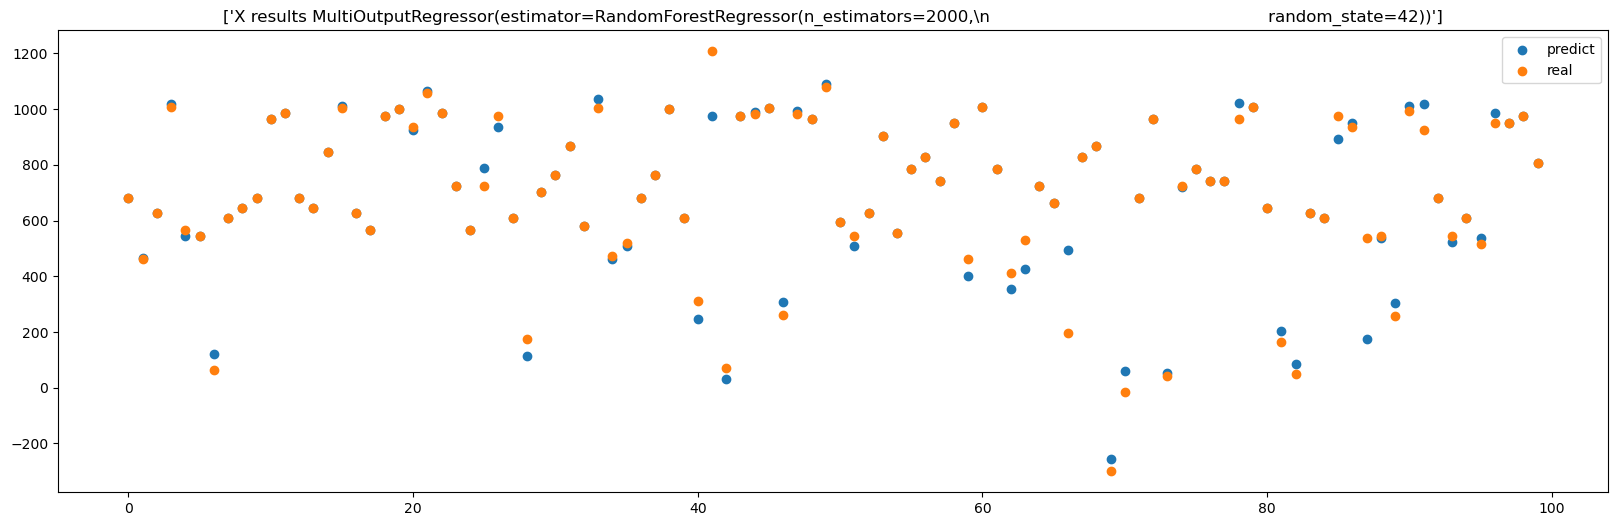

In [38]:
xcp, ycp = y_predict_test[:, 0], y_predict_test[:, 1]
xcr, ycr = y_test["x_closest"], y_test["y_closest"]


plt.scatter(range(len(xcp[:100])), xcp[:100])
plt.scatter(range(len(xcr[:100])), xcr[:100])
plt.legend(["predict", "real"])
plt.title(["X results " + str(regr_multirf)])
plt.show()    

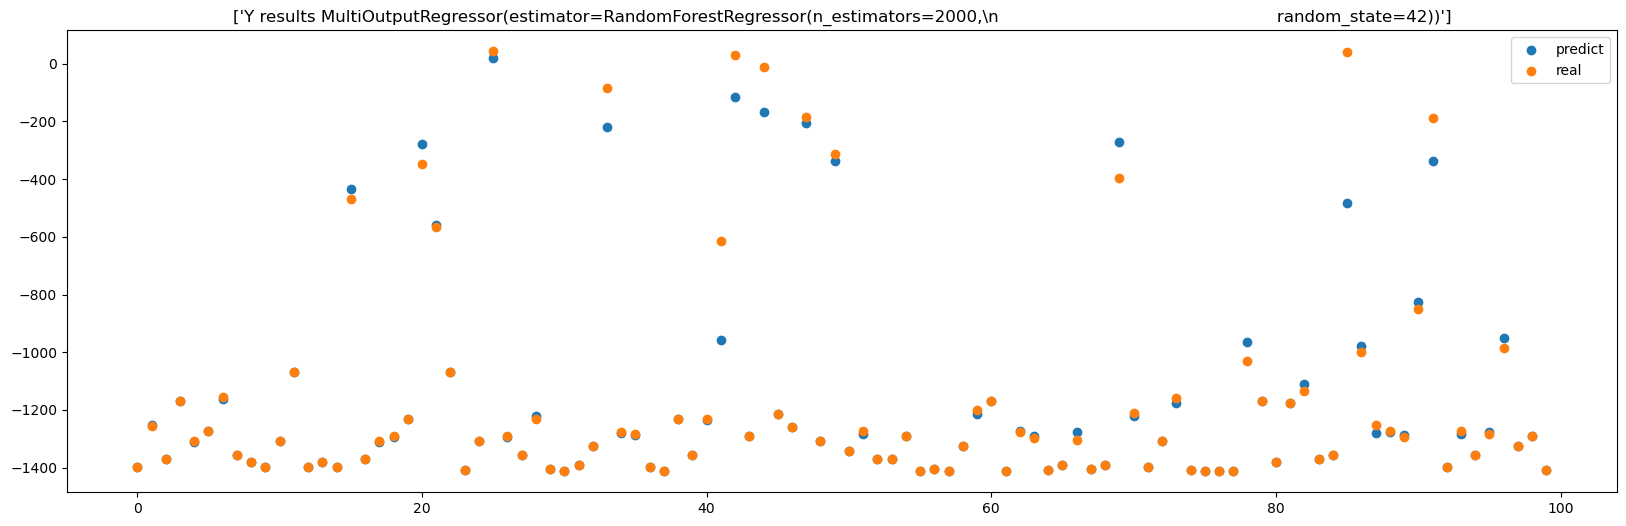

In [39]:
plt.scatter(range(len(ycp[:100])), ycp[:100])
plt.scatter(range(len(ycr[:100])), ycr[:100])
plt.legend(["predict", "real"])
plt.title(["Y results " + str(regr_multirf)])
plt.show()    

In [ ]:
# Train and evaluate the drift model
# drift_X_train, drift_X_test, drift_y_train, drift_y_test = split_data(df, predictor_cols, ["x_closest", "y_closest"])
# drift_model = train_drift_model(drift_X_train, drift_y_train)
# evaluate_drift_model(drift_model, drift_X_test, drift_y_test)
# save_model("drift_prediction_model", drift_model)